In [ ]:
import numpy as np
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from agtg import AGTG_Model

class EEGDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal_processed, Adj_dist_matrix, bdi_label = self.data[idx]
        return signal_processed, Adj_dist_matrix, bdi_label

def load_processed_data(file_path):
    return np.load(file_path, allow_pickle=True)

def save_processed_data(training_data, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label in training_data:
        subject_folder = os.path.join(output_folder, subject_id)
        if not os.path.exists(subject_folder):
            os.makedirs(subject_folder)

        np.save(os.path.join(subject_folder, "signal_processed.npy"), signal_processed)
        np.save(os.path.join(subject_folder, "Adj_dist_matrix.npy"), Adj_dist_matrix)
        np.save(os.path.join(subject_folder, "bdi_label.npy"), bdi_label)

def trainingData_iterator(data):
    processed_data = []
    for item in data:
        subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label = item
        processed_data.append((signal_processed, Adj_dist_matrix, bdi_label))
    return processed_data

def prepare_data(data):
    X = trainingData_iterator(data)
    return X

def train_test_datasets(dataSet, batch_size, train_test_split):
    train_size = int(len(dataSet) * train_test_split)
    test_size = len(dataSet) - train_size
    train_dataset, test_dataset = random_split(dataSet, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for signal_processed, Adj_dist_matrix, bdi_label in dataloader:
        signal_processed = signal_processed.to(device).float()
        Adj_dist_matrix = Adj_dist_matrix.to(device).float()
        bdi_label = bdi_label.to(device).float()

        optimizer.zero_grad()
        output = model(signal_processed, Adj_dist_matrix)
        loss = criterion(output, bdi_label)
        loss.backward()
        optimizer.step()

    print(f'Training Loss: {loss.item()}')

def main():
    # Load processed signals
    processed_signals_path = 'processed_signals.npy'
    training_data = load_processed_data(processed_signals_path)

    # Save processed data
    output_folder = "processed_data"
    save_processed_data(training_data, output_folder)

    # Prepare data for training
    data = prepare_data(training_data)
    dataset = EEGDataset(data)

    # Dataset and DataLoader
    batch_size = 40
    train_test_split_ratio = 0.7
    train_dataloader, test_dataloader = train_test_datasets(dataset, batch_size, train_test_split_ratio)

    # Model, loss function, optimizer
    nodes_dim = 16
    node_features_dim = 16
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AGTG_Model(nodes_dim, node_features_dim).to(device)
    criterion = nn.MSELoss()  # Change this to the appropriate loss for your task
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train(model, train_dataloader, criterion, optimizer, device)
        print(f'Epoch [{epoch+1}/{num_epochs}] completed.')

if __name__ == "__main__":
    main()


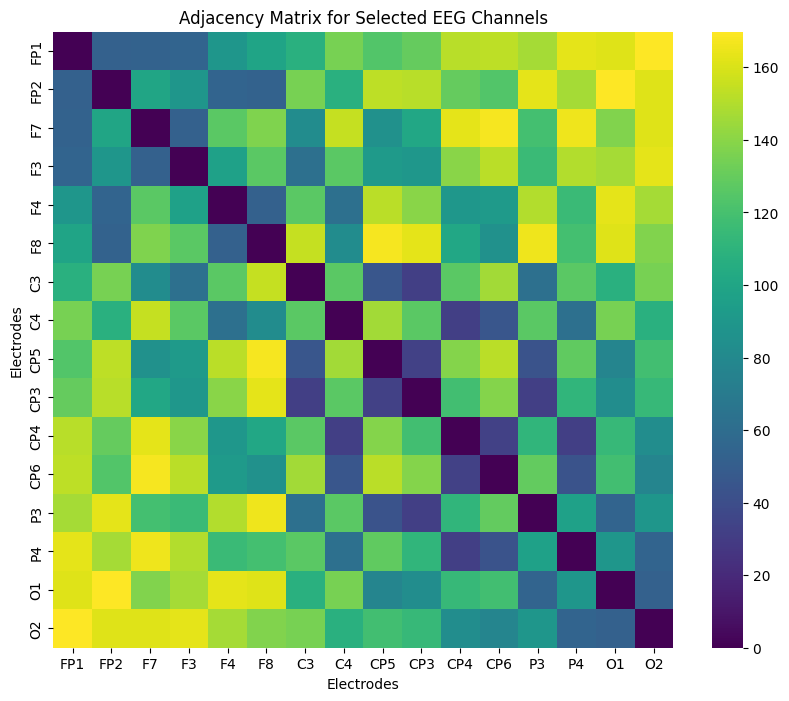

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

channelsList = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'CP3', 'CP4', 'CP5', 'CP6']

# Path to the electrodes.tsv file
electrodes_file_path = "/content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_electrodes.tsv"

# Read the electrodes.tsv file into a DataFrame
electrodes_df = pd.read_csv(electrodes_file_path, delimiter='\t')

# Filter the DataFrame to include only the specified channels
filtered_electrodes_df = electrodes_df[electrodes_df['name'].isin(channelsList)]

# Extract the electrode names and coordinates
electrode_names = filtered_electrodes_df['name']
electrode_coordinates = filtered_electrodes_df[['x', 'y', 'z']].values

# Calculate distances between electrodes to create the adjacency matrix
num_electrodes = len(electrode_names)
adjacency_matrix = np.zeros((num_electrodes, num_electrodes))

for i in range(num_electrodes):
    for j in range(i + 1, num_electrodes):
        # Calculate Euclidean distance between electrode i and electrode j
        distance = np.linalg.norm(electrode_coordinates[i] - electrode_coordinates[j])
        adjacency_matrix[i, j] = distance
        adjacency_matrix[j, i] = distance

# Plot the adjacency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_matrix, xticklabels=electrode_names, yticklabels=electrode_names, cmap='viridis', annot=False)
plt.title("Adjacency Matrix for Selected EEG Channels")
plt.xlabel("Electrodes")
plt.ylabel("Electrodes")
plt.savefig("adjacency_matrix.png", dpi=600)
plt.show()
